In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

# Chargement des données
df = pd.read_csv('../HR_Analytics_Structure_Complet.csv')

print("Données chargées. Taille :", df.shape)
# Aperçu de la cible
print("Répartition de la cible 'Attrition_Numeric' (0=Reste, 1=Départ) :")
print(df['Attrition_Numeric'].value_counts(normalize=True))

Données chargées. Taille : (1356, 34)
Répartition de la cible 'Attrition_Numeric' (0=Reste, 1=Départ) :
Attrition_Numeric
0    0.828909
1    0.171091
Name: proportion, dtype: float64


In [2]:
# 1. Sélection des features (On exclut les colonnes inutiles)
# Attrition_Numeric est notre cible (Target)
# On ne garde que les colonnes existantes à supprimer (Cible + ID)
X_raw = df.drop(['Attrition', 'Attrition_Numeric', 'EmployeeNumber'], axis=1)
y = df['Attrition_Numeric']

# 2. Encodage One-Hot (Transformation des textes en chiffres)
X_encoded = pd.get_dummies(X_raw, drop_first=True)

# 3. Normalisation (Scaling)
# Crucial pour la Régression Logistique pour que les coefficients soient comparables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# On remet en DataFrame pour garder les noms de colonnes (utile pour l'interprétation)
X = pd.DataFrame(X_scaled, columns=X_encoded.columns)

# Sauvegarde des colonnes pour la fonction de prédiction future
features_columns = X_encoded.columns.tolist()

print("--- Préparation terminée ---")
print(f"Nombre de features après encodage : {X.shape[1]}")

--- Préparation terminée ---
Nombre de features après encodage : 45


In [3]:
# Stratify=y assure qu'il y a la même proportion de départs dans le Train et le Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Split terminé.")
print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Split terminé.
Train shape: (1084, 45)
Test shape: (272, 45)


In [4]:
from sklearn.svm import SVC

# Probability=True est requis pour avoir predict_proba() dans la fonction de test
model = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
model.fit(X_train, y_train)

print("Modèle SVM (RBF) entraîné.")

Modèle SVM (RBF) entraîné.


 RÉSULTATS : SVM (Support Vector Machine)
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       225
           1       0.77      0.21      0.33        47

    accuracy                           0.85       272
   macro avg       0.81      0.60      0.63       272
weighted avg       0.84      0.85      0.82       272



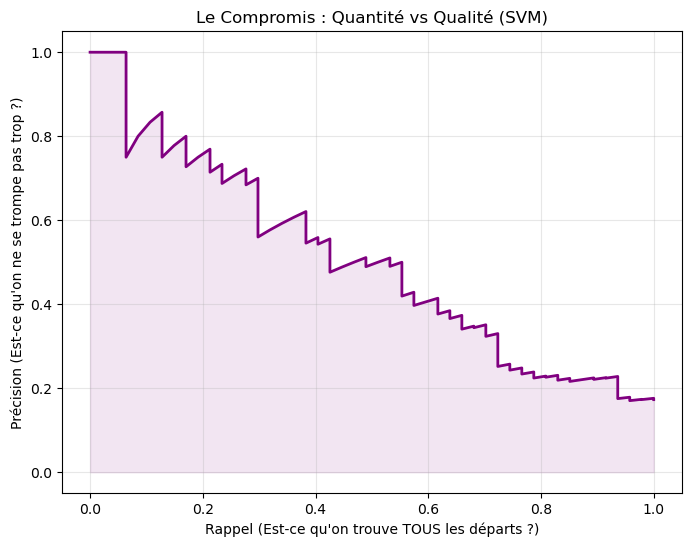

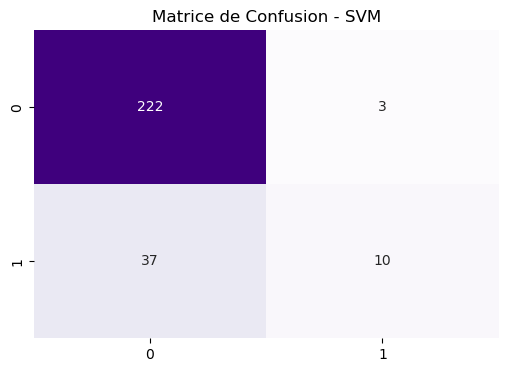

In [10]:
# Cellule 5 : Évaluation & Courbe Précision-Rappel
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("="*40)
print(" RÉSULTATS : SVM (Support Vector Machine)")
print("="*40)
print(classification_report(y_test, y_pred))

# --- GRAPHIQUE : Precision-Recall Curve ---
# Idéal quand il y a peu de départs (Données déséquilibrées)
precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Rappel (Est-ce qu\'on trouve TOUS les départs ?)')
plt.ylabel('Précision (Est-ce qu\'on ne se trompe pas trop ?)')
plt.title('Le Compromis : Quantité vs Qualité (SVM)')
plt.grid(True, alpha=0.3)
plt.fill_between(recall, precision, alpha=0.1, color='purple')
plt.show()

# Matrice
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Purples', cbar=False)
plt.title("Matrice de Confusion - SVM")
plt.show()

Courbe Précision-Rappel (Ligne Violette) : Ce graphique montre le dilemme du RH.

-Si on veut trouver tous les démissionnaires (aller vers la droite), on risque de suspecter des gens innocents (la courbe descend).

-Un bon modèle : La courbe reste haute le plus longtemps possible vers la droite.

-Un mauvais modèle : La courbe s'effondre tout de suite dès qu'on essaie de trouver plus de monde.

Dans ce cas, la courbe violette illustre parfaitement le comportement élitiste du SVM. Elle commence très haut sur l'axe vertical (haute Précision), mais s'effondre brutalement dès qu'on avance sur l'axe horizontal (Rappel). Cela nous dit visuellement que le modèle est excellent pour identifier une petite poignée de départs "évidents", mais qu'il abandonne dès que le cas devient ambigu. Il privilégie la qualité (Précision 77%) à la quantité.

In [6]:
def predire_demission(input_data, model, scaler, model_columns):
    """
    Simule une prédiction pour un nouvel employé.
    """
    # 1. Création DataFrame
    input_df = pd.DataFrame([input_data])
    
    # 2. Encodage (Get Dummies)
    input_encoded = pd.get_dummies(input_df)
    
    # 3. Alignement des colonnes (Ajout des colonnes manquantes avec 0)
    input_encoded = input_encoded.reindex(columns=model_columns, fill_value=0)
    
    # 4. Scaling (Utilisation du scaler entraîné)
    input_scaled = scaler.transform(input_encoded)

    # On remet les données dans un DataFrame avec les noms
    input_scaled_df = pd.DataFrame(input_scaled, columns=input_encoded.columns)
    
    # 5. Prédiction (Probabilité)
    proba = model.predict_proba(input_scaled_df)[0][1] # Proba de la classe 1 (Départ)
    prediction = "Va Partir (Risque Élevé)" if proba > 0.5 else "Va Rester"
    
    return prediction, proba


In [7]:
# --- TEST ---
profil_employe = {
    'Age': 29,
    'DailyRate': 400,
    'DistanceFromHome': 25, # Loin
    'EnvironmentSatisfaction': 1, # Très insatisfait
    'JobSatisfaction': 1, # Très insatisfait
    'OverTime': 'Yes', # Heures supp
    'Department': 'Sales',
    'JobRole': 'Sales Executive'
}

resultat, proba = predire_demission(profil_employe, model, scaler, features_columns)

print(f"Profil Test : {profil_employe}")
print(f"Résultat : {resultat}")
print(f"Probabilité de départ : {proba:.2%}")

Profil Test : {'Age': 29, 'DailyRate': 400, 'DistanceFromHome': 25, 'EnvironmentSatisfaction': 1, 'JobSatisfaction': 1, 'OverTime': 'Yes', 'Department': 'Sales', 'JobRole': 'Sales Executive'}
Résultat : Va Partir (Risque Élevé)
Probabilité de départ : 50.86%


In [8]:
artefacts = {'model': model, 'scaler': scaler, 'features': features_columns}
joblib.dump(artefacts, '../Models/modele_classif_svm.pkl')
print("Modèle SVM sauvegardé.")

Modèle SVM sauvegardé.


Conclusion :

 SVM Le SVM est très puissant pour trouver des frontières complexes, mais c'est une "boîte noire" difficile à interpréter pour les RH.